In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("presentation")
from scipy.signal import find_peaks
from scipy import integrate
from scipy.optimize import curve_fit
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline as us

basedir = "/home/joey/Documents/quest_b1021/CK1/"

def derivative(x,y):
    dx = x[1]-x[0]
    i=0
    dydx=np.gradient(y,dx)
    return dydx

def find_greater_than_n(x,n):
    for element in x:
        if element<=n:
            continue
        else:
            #return element
            return x.index(element)
            break
            
def find_less_than_n(x,n):
    for element in x:
        if element>=n:
            continue
        else:
            #return element
            return x.index(element)
            break


In [3]:
class GMX_Bilayer:
    def __init__(self,directory):
        self.basedir=directory
    def order(self,file,write=False):
        text_rows=17
        columns=["atom","Sxx","Syy","Szz"]
        df = self.read_xvg(file,text_rows,columns)
        theta = [np.arccos((2*s+1)/3) for s in df["Szz"]] #molecular angle from only the Szz component
        theta_deg = [(180/np.pi)*th for th in theta]
        df["$\theta$"]=theta
        df["$\theta({\cdot})$"]=theta_deg
        if write:
            self.write(self.basedir+file,df)
        return df
    def density(self,file,group,units="kg/m^3",write=False):
        text_rows=24
        columns = ["z","density(kg/m^3)"]
        df = self.read_xvg(file,text_rows,columns)
        if units == "e/nm^3":
            df.columns=[columns[0],"density(e/nm^3)"]
        if write:
            self.write(self.basedir+file,df)
        return {group:df}
    def total_density(self,file_list,groups,units,write=False):
        if len(file_list)==len(groups):
            dens_list=[self.density(file_list[i],groups[i],units=units) for i in range(0,len(file_list))]
        else:
            print("Error: number of files does not match number of groups!")
        temp=np.zeros(len(dens_list[0][groups[0]]["density("+units+")"]))
        for i in range(0,len(dens_list)):
            temp+=dens_list[i][groups[i]]["density("+units+")"]
        df_total=pd.DataFrame({"z":dens_list[0][groups[0]]["z"],dens_list[0][groups[0]].columns[1]:temp})
        if write:
            self.write(self.basedir+file,df_total)
        return df_total    
    def rdf(self,file,group,write=False):
        text_rows=25
        columns = ["r","g(r)"]
        df = self.read_xvg(file,text_rows,columns)
        if write:
            self.write(self.basedir+file,df)
        return {group:df}
    def structure_factor(self,file,group,write=False):
        q_values=np.arange(0.001,10,0.1)
        structure_factor=[]
        rho=1 #scaling factor
        df=self.rdf(file,group)[group]
        r_values=df['r'].values
        for q in q_values:
            r_int = []
            for i in range(0, len(r_values)):
                r_int.append(r_values[i]*np.sin(q*r_values[i])*(df["g(r)"][i]-1))
            temp = integrate.trapz(r_int,r_values)
            temp*=4*np.pi*rho/q
            temp+=1
            structure_factor.append(temp)
        return pd.DataFrame({"q":q_values,"SF":structure_factor})
    def interactions(self,file,force_type,units="energy(kJ/mol)",write=False):
        text_rows=24
        columns = ["time","energy(kJ/mol)"]
        df = self.read_xvg(file,text_rows,columns)
        if units=="kT":
            # J to kbT (T=300K)
            conv = 2.479 #1kT = 2.479 kJ/mol (kT*N_A) 22/conv #4000kJ/1mol to ~22kJ/180mol
            molecules=180 #need total number of molecules in interactions to perform conversion
            df[df.columns[1]]=df[df.columns[1]]/conv/molecules
            df.columns=[columns[0],"energy(kT)"]
        if write:
            self.write(self.basedir+file,df)
        return {force_type:df}
    def apl(self,file,write=False):
        columns = ["time","apl($\AA^2$/lipid)"]
        df = pd.read_csv(self.basedir+file,header=1,names=columns)
        if write:
            self.write(self.basedir+file,df)
        return df
    def plot_df(self,df,i,j,labels=None):
        plt.figure()
        x=df.columns[i]
        y=df.columns[j]
        plt.plot(df[x],df[y],label=labels)
        plt.legend(bbox_to_anchor =(1, 1))
        plt.xlabel(x)
        plt.ylabel(y)
    def height(self,file_list,groups,units,write=False):
        # Calculates height of bilayers based on first and second derivatives of total density plots
        df = self.total_density(file_list,groups,units)
        x=df['z'].values
        y=df['density('+units+")"].values
        first=find_peaks(derivative(x,y),height=500)[0][0]
        second=find_peaks(derivative(x,-y),height=500)[0][1]
        first_2=find_peaks(derivative(x,derivative(x,y)),height=500)[0][0]
        second_2=find_peaks(derivative(x[::-1],derivative(x[::-1],y)),height=500)[0][0]
        peak_index=[first,second]
        peak_index_2=[first_2,second_2]
        plt.figure()
        for index in peak_index:
            plt.scatter(x[index],y[index],color="#44AA99")
        plt.scatter(x[peak_index_2[0]],y[peak_index_2[0]],color="#AA4499")
        plt.scatter(x[len(x)-peak_index_2[1]-1],y[len(x)-peak_index_2[1]-1],color="#AA4499")
        height = x[peak_index[1]]-x[peak_index[0]]
        height_2 = x[len(x)-peak_index_2[1]-1]-x[peak_index_2[0]]
        plt.plot(x,y,label="f")#,label="thickness (nm)= %f"%height)
        plt.plot(x,derivative(x,y),label="f'")
        plt.plot(x,derivative(x,derivative(x,y)),label="f''")
        plt.ylabel("Density ("+units+")")
        plt.xlabel("z (nm)")
        plt.legend(bbox_to_anchor =(1, 1))
        print("Bilayer height 1st Deriv (nm) = {}".format(height))
        print("Bilayer height 2nd Deriv (nm) = {}".format(height_2))
        return({"Height 1st Deriv":height,"Height 2nd Deriv":height_2})
    def height_intersection(self,head_file,water_file,units):
        # Calculates height of bilayer based on intersection of head group and water density plots
        dict_h=self.density(head_file,"Headgroups")
        dict_w=self.density(water_file,"Water")
        f1=interp1d(dict_h["Headgroups"]["z"],dict_h["Headgroups"]["density(kg/m^3)"],"cubic")
        f2=interp1d(dict_w["Water"]["z"],dict_w["Water"]["density(kg/m^3)"],"cubic")
        x=np.linspace(1,8,1000)
        epsilon=11.79
        index_list=np.where(abs(f1(x)-f2(x))<epsilon)
        index_list_trunc=[]
        for i in index_list[0]:
            y=f1(x)[i]
            if y==0.0:
                continue
            elif abs(y)<100:
                continue
            else:
                index_list_trunc.append(i)
        plt.figure()
        plt.plot(x,f1(x))
        plt.plot(x,f2(x))
        for i in index_list_trunc:
            plt.scatter(x[i],f1(x)[i],color="#AA4499")
        height=x[index_list_trunc[1]]-x[index_list_trunc[0]]
        plt.ylabel("Density ("+units+")")
        plt.xlabel("z (nm)")
        print(head_file)
        print("Bilayer height (nm) = {}".format(height))
        return height
    def fit_horizontal(self,df,i,j):
        def func(x,b):
            return b
        popt,pcov=curve_fit(func,df[df.columns[i]],df[df.columns[j]])
        print("Fit: f(x) = b, b = {}".format(popt[0]))
        return popt[0]
    def fit_line(self,df,i,j):
        def func(x,a,b):
            return a*x+b
        popt,pcov=curve_fit(func,df[df.columns[i]],df[df.columns[j]])
        print("Fit: f(x) = ax + b, a = {}, b = {}".format(popt[0],popt[1]))
        return [popt[0],popt[1]]
    def write(self,file,df):
        df.to_csv(file.replace("xvg","csv"))
    def read_xvg(self,file,text_rows,columns):
        df=pd.read_csv(self.basedir+file,sep = "\s+",skiprows=text_rows,header=None,names=columns)
        return df

In [4]:
bilayer=GMX_Bilayer(basedir+"L_C16K_charge_variation/10nm_box/")
bilayer2=GMX_Bilayer(basedir+"C12/charge_variation/10nm_box/")
bilayer3=GMX_Bilayer(basedir+"C14/charge_variation/10nm_box/")

Bilayer height 1st Deriv (nm) = 2.863670000000001
Bilayer height 2nd Deriv (nm) = 3.1940899999999997
0/combined/dens_head.xvg
Bilayer height (nm) = 3.3493493493493496


3.3493493493493496

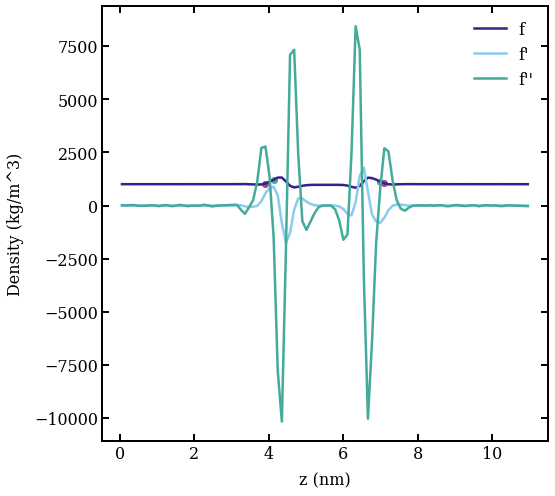

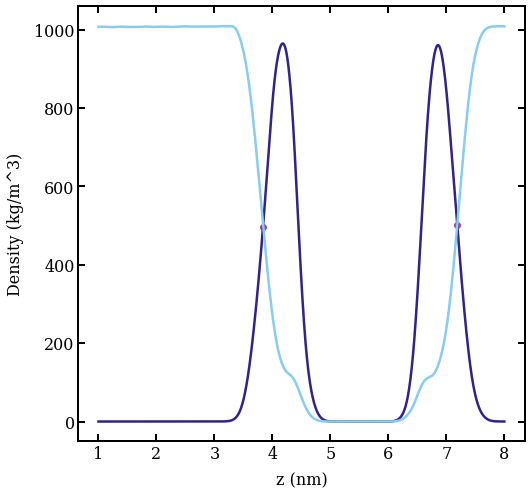

In [50]:
bilayer.height(["0/combined/dens_head.xvg","0/combined/dens_water.xvg","0/combined/dens_tails.xvg"],["Head","Water","Tails"],units="kg/m^3")
bilayer.height_intersection("0/combined/dens_head.xvg","0/combined/dens_water.xvg",units="kg/m^3")

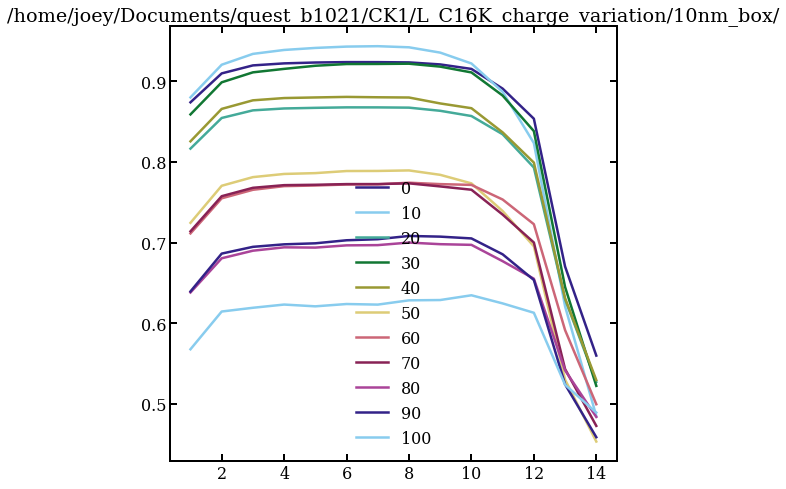

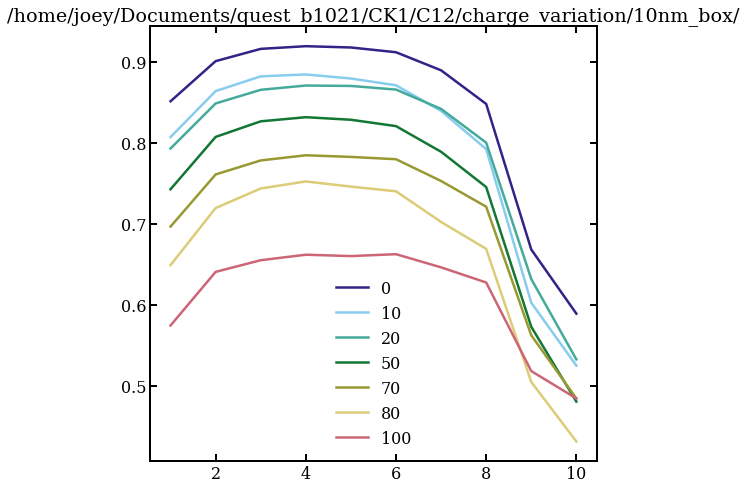

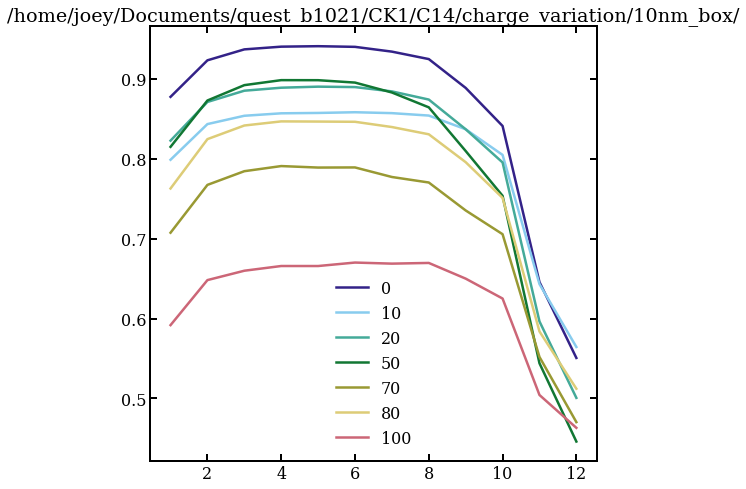

In [51]:
charge=["0","10","20","30","40","50","60","70","80","90","100"]
plt.figure()
for c in charge:
    df = bilayer.order(c+"/combined/order.xvg")
    plt.plot(df[df.columns[0]],df[df.columns[3]],label=c)
plt.title(bilayer.basedir)
plt.legend()

charge2=["0","10","20","50","70","80","100"]
plt.figure()
for c in charge2:
    df = bilayer2.order(c+"/combined/order.xvg")
    plt.plot(df[df.columns[0]],df[df.columns[3]],label=c)
plt.title(bilayer2.basedir)
plt.legend()

charge2=["0","10","20","50","70","80","100"]
plt.figure()
for c in charge2:
    df = bilayer3.order(c+"/combined/order.xvg")
    plt.plot(df[df.columns[0]],df[df.columns[3]],label=c)
plt.title(bilayer3.basedir)
plt.legend()

0/combined/dens_head.xvg
Bilayer height (nm) = 3.3493493493493496
10/combined/dens_head.xvg
Bilayer height (nm) = 3.3423423423423424
20/combined/dens_head.xvg
Bilayer height (nm) = 3.2232232232232234
30/combined/dens_head.xvg
Bilayer height (nm) = 3.3703703703703702
40/combined/dens_head.xvg
Bilayer height (nm) = 3.1531531531531534
50/combined/dens_head.xvg
Bilayer height (nm) = 3.2582582582582584
60/combined/dens_head.xvg
Bilayer height (nm) = 3.132132132132132
70/combined/dens_head.xvg
Bilayer height (nm) = 0.007007007007006738
80/combined/dens_head.xvg
Bilayer height (nm) = 3.0830830830830824
90/combined/dens_head.xvg
Bilayer height (nm) = 3.132132132132132
100/combined/dens_head.xvg
Bilayer height (nm) = 2.963963963963964


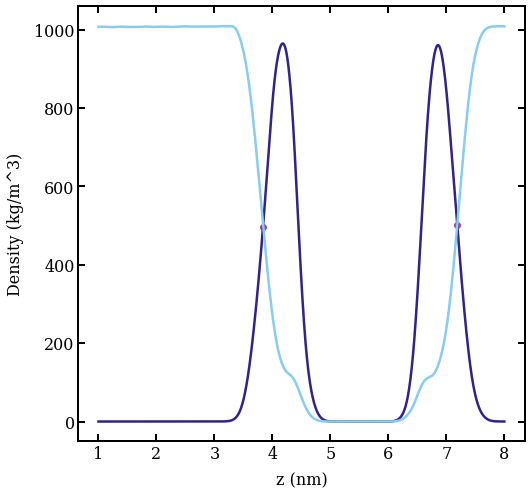

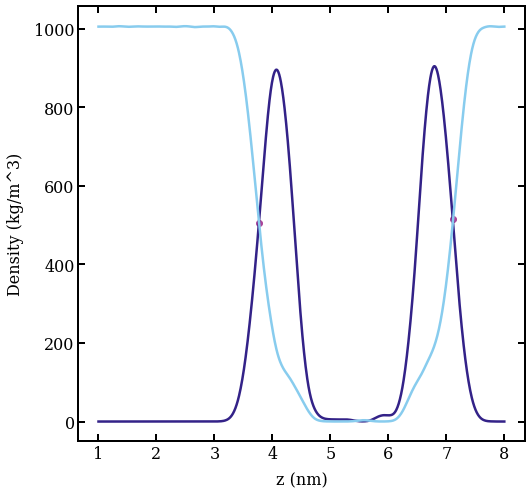

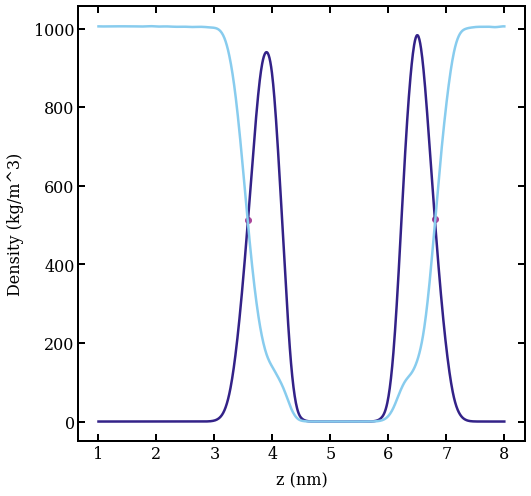

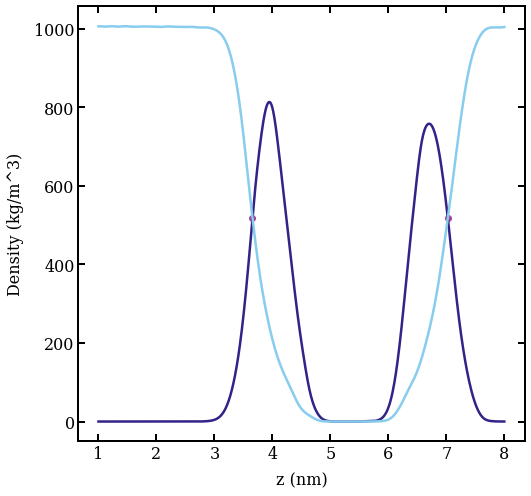

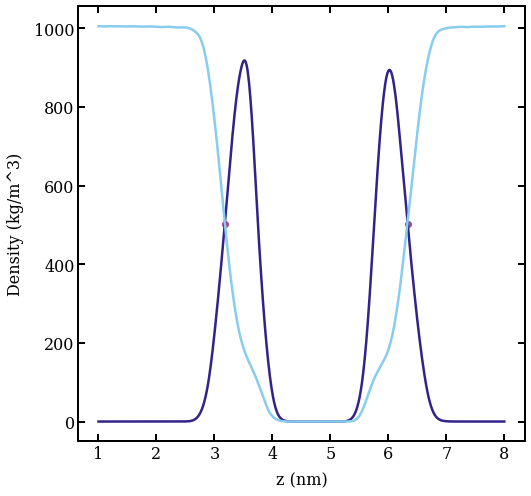

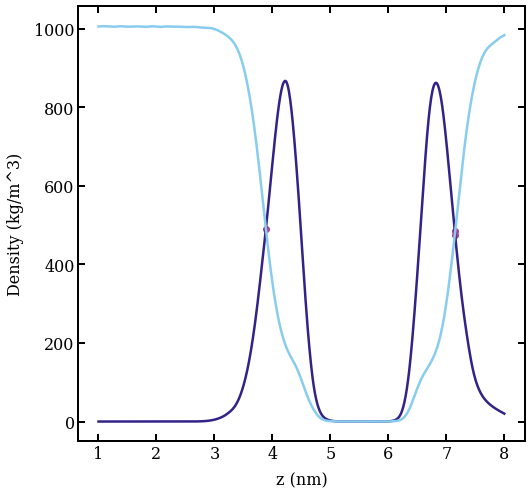

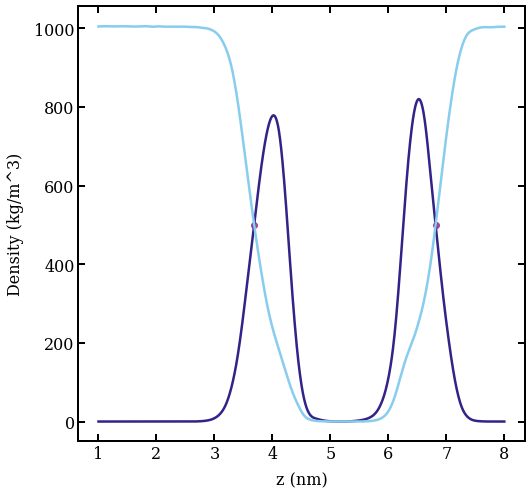

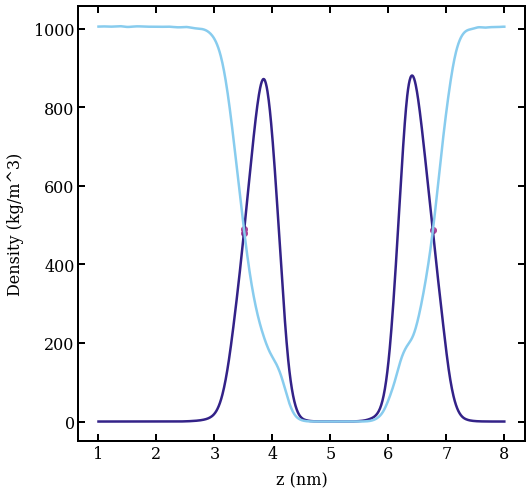

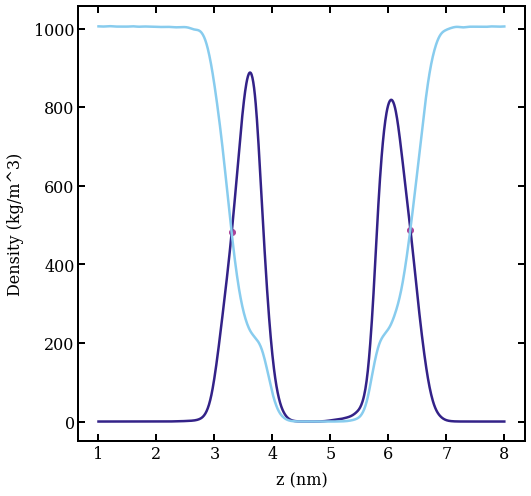

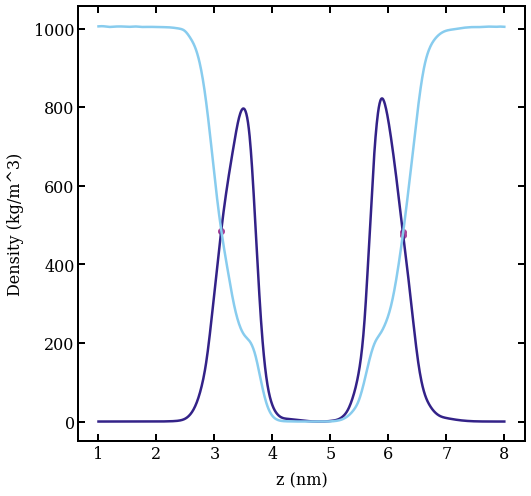

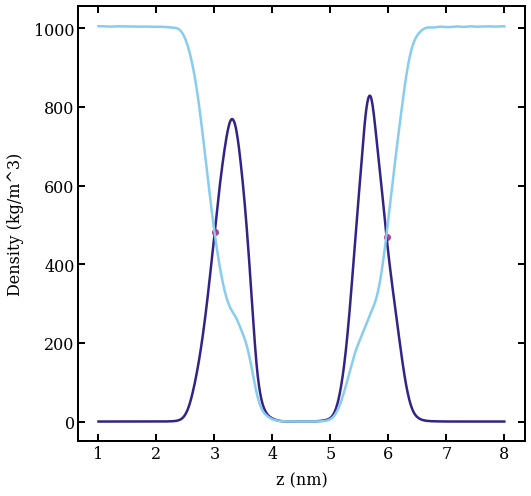

In [55]:
for c in charge:
    bilayer.height_intersection(c+"/combined/dens_head.xvg",c+"/combined/dens_water.xvg",units="kg/m^3")
    #bilayer.height([c+"/combined/dens_head.xvg",c+"/combined/dens_water.xvg",c+"/combined/dens_tails.xvg"],["Head","Water","Tails"],units="kg/m^3")

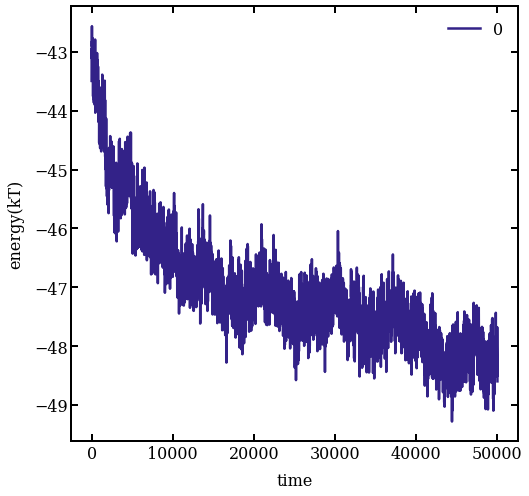

In [5]:
bilayer.plot_df(bilayer.interactions("0/LJ_sr_pp.xvg","LJ",units="kT")["LJ"],0,1,labels="0")

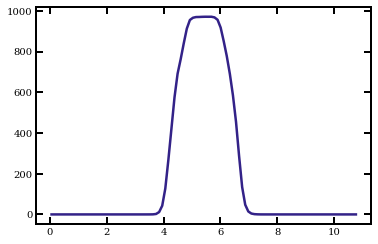

In [36]:
df1=bilayer.density("0/dens_tails.xvg","tail")["tail"]
x=df1[df1.columns[0]].values
y=df1[df1.columns[1]].values
plt.plot(x,y)
def gaussian(x,sigma1,mu1,s1):
    return s1/(sigma1*np.sqrt(2*np.pi))*(np.exp(-(1/2)*((x-mu1)/sigma1)**2))
def gaussian2(x,sigma1,mu1,sigma2,mu2,s1,s2):
    return s1*(np.exp(-(1/2)*((x-mu1)/sigma1)**2)) + s2*(np.exp(-(1/2)*((x-mu2)/sigma2)**2))

In [45]:
guess=[0.6,4.5,0.6,6,1000,1000]
popt,pcov=curve_fit(gaussian2,x,y,p0=guess)
popt

array([4.62919571e-01, 4.88688077e+00, 4.64645407e-01, 5.95058760e+00,
       9.04413411e+02, 9.07234360e+02])

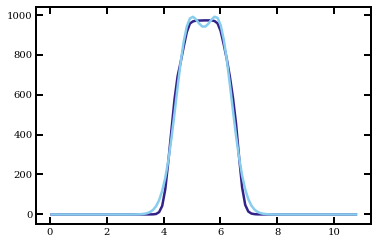

In [47]:
plt.plot(x,y)
plt.plot(x,gaussian2(x,*popt))

In [49]:
2.4*popt[0]
2.4*popt[2]

1.1151489769291154

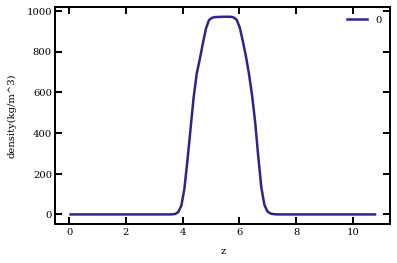

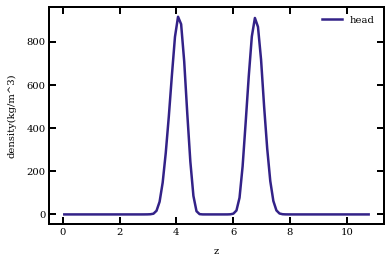

In [55]:
#bilayer.plot_df(bilayer.interactions("0/LJ_sr_pp.xvg","LJ",units="kT")["LJ"],0,1,labels="0")
bilayer.plot_df(df1,0,1,labels="0")
bilayer.plot_df(bilayer.density("0/dens_head.xvg","head")["head"],0,1,labels="head")

In [5]:
df1=bilayer.total_density(["100_copy/dens_head_cont_e.xvg","100_copy/dens_water_cont_e.xvg","100_copy/dens_tails_cont_e.xvg","100_copy/dens_ions_cont_e.xvg"],["Head","Water","Tails","Ions"],units="e/nm^3")
df2=bilayer.total_density(["100/combined_e_dens_head.xvg","100/combined_e_dens_water.xvg","100/combined_e_dens_tails.xvg","100/combined_e_dens_ions.xvg"],["Head","Water","Tails","Ions"],units="e/nm^3")

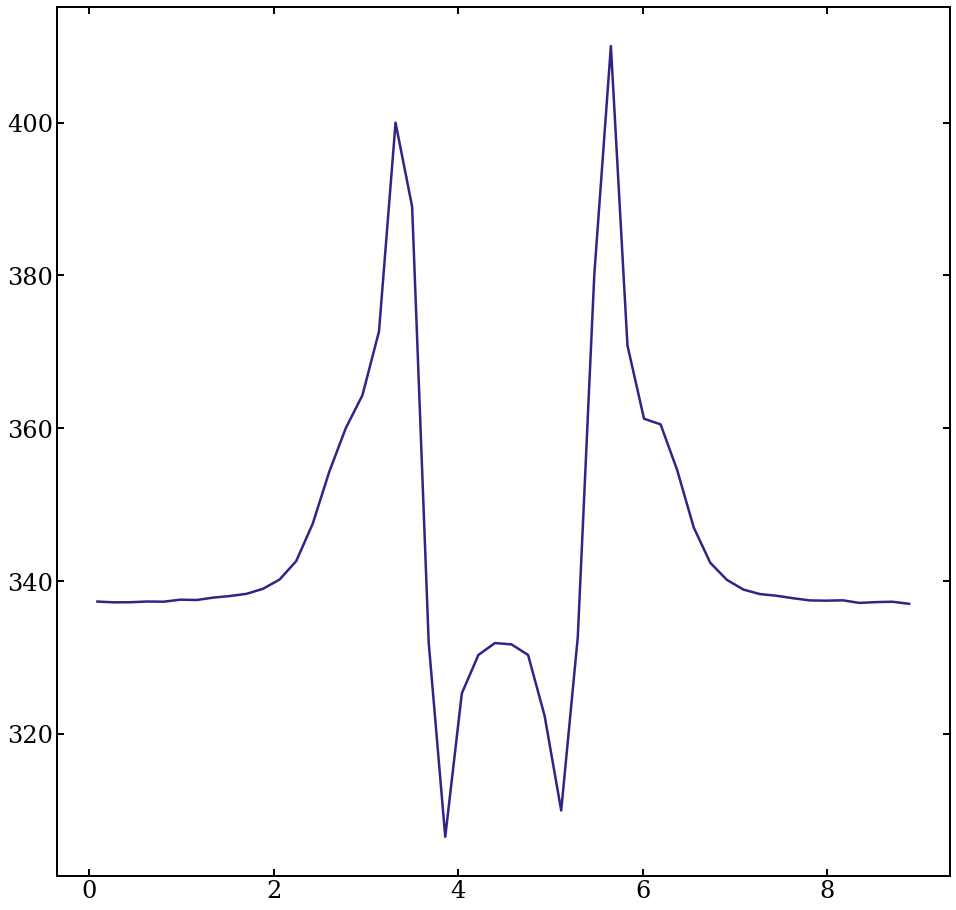

In [6]:
#plt.plot(df1[df1.columns[0]],df1[df1.columns[1]])
plt.plot(df2[df2.columns[0]],df2[df2.columns[1]])

In [7]:
dfc12=bilayer2.total_density(["100/combined_e_dens_head.xvg","100/combined_e_dens_water.xvg","100/combined_e_dens_tails.xvg","100/combined_e_dens_ions.xvg"],["Head","Water","Tails","Ions"],units="e/nm^3")

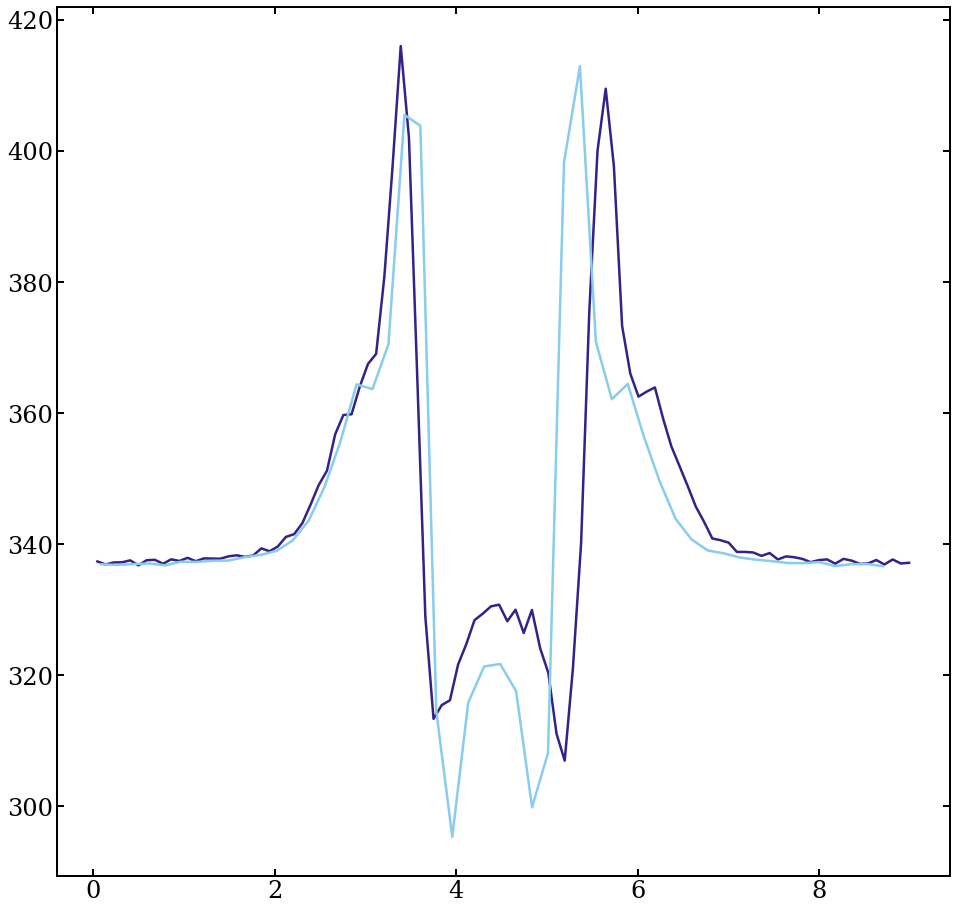

In [8]:
plt.plot(df1[df1.columns[0]],df1[df1.columns[1]])
plt.plot(dfc12[dfc12.columns[0]],dfc12[dfc12.columns[1]])

In [107]:
f1=us(df1[df1.columns[0]],df1[df1.columns[1]])

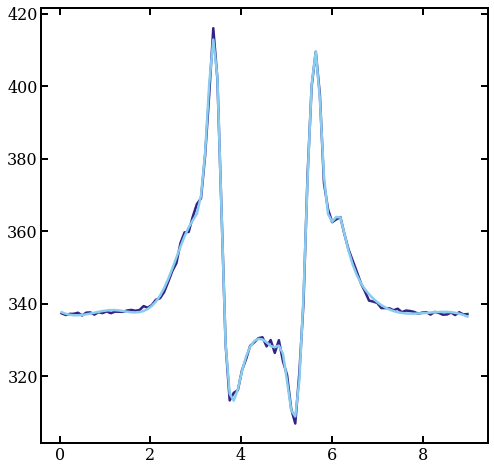

In [114]:
plt.plot(df1[df1.columns[0]],df1[df1.columns[1]])
plt.plot(df1[df1.columns[0]],f1(df1[df1.columns[0]]))

In [112]:
df1["spline"]=f1(df1[df1.columns[0]])

In [9]:
#df1.to_csv("L_C16K_charge_variation/10nm_box/100_copy/e_density_100.csv")
#df2.to_csv("L_C16K_charge_variation/10nm_box/100/e_density_100.csv")
dfc12.to_csv("C12/charge_variation/10nm_box/100/e_density_100.csv")


In [11]:
d1=bilayer.order("100"+"/combined/order.xvg")
d2=bilayer.order("0"+"/combined/order.xvg")

In [25]:
d1

,atom,Sxx,Syy,Szz,$\theta$,$\theta({\cdot})$
0,1,-0.263569,-0.304433,0.568006,0.778448,44.601799
1,2,-0.291558,-0.323239,0.614796,0.732960,41.995504
2,3,-0.290591,-0.328838,0.619429,0.728332,41.730324
3,4,-0.291924,-0.331507,0.623429,0.724316,41.500264
4,5,-0.288382,-0.332844,0.621226,0.726530,41.627098
5,6,-0.289690,-0.334403,0.624091,0.723650,41.462088
6,7,-0.287557,-0.335800,0.623358,0.724388,41.504357
7,8,-0.291733,-0.336929,0.628662,0.719036,41.197701
8,9,-0.290630,-0.338409,0.629037,0.718656,41.175950
9,10,-0.296197,-0.338733,0.634930,0.712668,40.832876


In [27]:
for i in range(0,len(d1)):
    S = np.sqrt(d1['Sxx'][i]**2+d1['Syy'][i]**2+d1['Szz'][i]**2)
    print((180/np.pi)*(np.arccos(d1['Sxx'][i]/(S*np.sin(d1['$\theta$'][i])))))

122.62302912830472
125.34319518449459
125.10625921733907
125.21209696122007
124.75723052028232
124.88361832831451
124.5979215798604
125.08297331977452
124.9204219780948
125.59891106564476
124.85713470182453
123.63679784086443
119.00580202335152
115.77683321354796


In [33]:
print(100)
for i in range(0,len(d1)):
    print((180/np.pi)*np.arctan(d1['Syy'][i]/d1['Sxx'][i]))

print(0)
for i in range(0,len(d2)):
    print((180/np.pi)*np.arctan(d2['Syy'][i]/d2['Sxx'][i]))

100
49.11496396755269
47.94988987701478
48.533275204909955
48.63295800416778
49.09375729727411
49.0979410274091
49.425427832635506
49.11205461495317
49.34359188323405
48.83270130465871
49.17675186778779
50.10857428323001
52.38563687870158
56.00126000797115
0
45.724232158373546
45.60529129554909
45.534312375489584
45.54745577679033
45.56710671362308
45.57963242043674
45.598380214703866
45.60367619221455
45.63859690902204
45.72595296317187
45.819907329595495
46.397868041760674
46.200097525726854
49.36865242699335


In [34]:
charge=["0","10","20","30","40","50","60","70","80","90","100"]
for c in charge:
    d=bilayer.order(c+"/combined/order.xvg")
    print(c)
    for i in range(0,len(d)):
        print((180/np.pi)*np.arctan(d['Syy'][i]/d['Sxx'][i]))
    print('\n')

0
45.724232158373546
45.60529129554909
45.534312375489584
45.54745577679033
45.56710671362308
45.57963242043674
45.598380214703866
45.60367619221455
45.63859690902204
45.72595296317187
45.819907329595495
46.397868041760674
46.200097525726854
49.36865242699335


10
45.56854618094627
45.471861452855926
45.35676425433212
45.343380323039305
45.41347360488129
45.373085783968335
45.36936384206104
45.39167115425452
45.391060679727296
45.45578128218438
45.45368917934267
45.57014104663154
45.08541442358589
46.753428935691666


20
45.448048755024644
45.29145625292421
45.27487697106796
45.29317498961755
45.348074843568206
45.3532497732901
45.37003434791581
45.344677297525955
45.29747507285396
45.28642804892939
45.31321012805078
45.95659823032399
45.40205244965807
48.0616425829778


30
45.68745901076462
45.63389996664128
45.490952934647
45.49509498014998
45.49886612159993
45.492927088977794
45.45439327272849
45.428270863521604
45.47137985277356
45.50151610219689
45.621741740099104
45.8240616736775

In [36]:
charge=["0","10","20","50","70","80","100"]
for c in charge:
    d=bilayer2.order(c+"/combined/order.xvg")
    print(c)
    for i in range(0,len(d)):
        print((180/np.pi)*np.arctan(d['Syy'][i]/d['Sxx'][i]))
    print('\n')
    
charge=["0","10","20","50","70","80","100"]
for c in charge:
    d=bilayer3.order(c+"/combined/order.xvg")
    print(c)
    for i in range(0,len(d)):
        print((180/np.pi)*np.arctan(d['Syy'][i]/d['Sxx'][i]))
    print('\n')

0
45.51058740254846
45.57074747858145
45.5303280849067
45.54443798727504
45.594416038187845
45.69202347064855
45.917172743557096
46.54126771525321
46.73943929139282
48.85295938861848


10
45.125141625494315
45.13456916234657
45.156805922699306
45.1416128774142
45.14138064463165
45.22269792689842
45.29816526398391
45.974974614174144
45.60724678427191
47.28264509223256


20
45.41729192244765
45.451625723017294
45.47024044371027
45.45501874249355
45.51370292470169
45.59415715535965
45.781954206767686
46.54753085902669
47.0544156149834
50.39399064841475


50
45.53720600062097
45.51713138431221
45.65839811570347
45.61859583130243
45.67263050811766
45.758903489299165
45.931255410482954
46.9129499430623
47.155209532365454
50.62809932525504


70
46.02309336107848
45.712301668932255
45.93713632758528
45.84952877694206
45.98618603630761
46.04020495266519
46.392244161205134
47.2483089456749
48.22048584163721
51.85346127790319


80
44.75260028978785
44.661047337447386
44.97278850178006
44.91946049